In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import recall_score, make_scorer, roc_auc_score
import os
import pickle
from dotenv import load_dotenv

load_dotenv(override=True)
specificity = make_scorer(recall_score, pos_label=0)

In [6]:
load_dotenv(override=True)

True

In [7]:
connection_string = f'mssql+pymssql://@{os.getenv('HOSTNAME')}/{os.getenv('DATABASE')}'
engine = sqlalchemy.create_engine(connection_string)

sql_string = f'''
select
    *
from {os.getenv('DATABASE')}.{os.getenv('SCHEMA')}.rpt_depression
'''
print("transfering data from database")
dat = pd.read_sql(sql_string, con=engine)

transfering data from database


In [27]:
from preprocess import preprocess
from collections import defaultdict

outputs = pd.DataFrame(columns=[
    'min_sample_split',
    'all_auc_mean',
    'all_auc_std',
    'black_auc_mean',
    'black_auc_std',
    'hispanic_auc_mean',
    'hispanic_auc_std',
    'white_auc_mean',
    'white_auc_std'
])

race_cols = ['all', 'mother_is_black', 'mother_is_hispanic', 'mother_is_white']

for min_samples_split in range(5, 55, 5):
    clf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=200, min_samples_split=min_samples_split)
    tmp_list = [min_samples_split]
    aucs = defaultdict(list)

    for seed in range(10):
        dat_test = dat.sample(frac=float(os.getenv('TEST_SIZE')), random_state=seed)
        dat_train = dat.drop(dat_test.index).reset_index(drop=True)
        dat_test = dat_test.reset_index(drop=True)

        preprocess(dat_train);
        preprocess(dat_test);

        dat_train_selected = dat_train[ (dat_train['edinburgh_max'].isna() == False) | (dat_train['phq9_total_max'].isna() == False)].copy()

        # set up the X, y for model fitting
        X = dat_train_selected.drop(columns=['F53_label','edinburgh_max','phq9_total_max', 'birthid', 'PPD_delete_label'])
        y = np.where( (dat_train_selected['edinburgh_max'] >= 10) | 
                      (dat_train_selected['phq9_total_max'] >= 10) | 
                      (dat_train_selected['F53_label'] == 1), 1, 0)
        
        clf.fit(X, y)

        # test
        dat_test_selected = dat_test[ (dat_test['edinburgh_max'].isna() == False) | (dat_test['phq9_total_max'].isna() == False)].copy()
        X = dat_test_selected.drop(columns=['F53_label','edinburgh_max','phq9_total_max', 'birthid', 'PPD_delete_label'])
        y = np.where( (dat_test_selected['edinburgh_max'] >= 10) | 
                      (dat_test_selected['phq9_total_max'] >= 10) | 
                      (dat_test_selected['F53_label'] == 1), 1, 0)
        y_pred = clf.predict(X)
        y_pred_prob = clf.predict_proba(X)

        for col in race_cols:
            if col == 'all':
                y_selected = y
                y_pred_selected = y_pred
                y_pred_prob_selected = y_pred_prob
            else:
                idx = (X[col] == 1)
                y_selected = y[idx]
                y_pred_selected = y_pred[idx]
                y_pred_prob_selected = y_pred_prob[idx]
            aucs[col].append(roc_auc_score(y_selected, y_pred_prob_selected[:, 1]))
        
    # assembol the acus
    for col in race_cols:
        tmp_list.append(np.mean(aucs[col]))
        tmp_list.append(np.std(aucs[col]))
    outputs.loc[len(outputs)] = tmp_list
    print(outputs)

dropping 26 of census tract columns
found columns with NaN: bmi, NaN number = 319, dropping these patients
found columns with NaN: mother_age, NaN number = 32, dropping these patients
found columns with NaN: mother_height, NaN number = 499, dropping these patients
found columns with NaN: smoking, NaN number = 6, dropping these patients
found columns with NaN: tobacco, NaN number = 6, dropping these patients
removing patients without prenatal and postpartum visit 1054
dropping columns: counts_of_visits_3m_after_delivery, counts_of_visits_6m_after_delivery
dropping 26 of census tract columns
found columns with NaN: bmi, NaN number = 88, dropping these patients
found columns with NaN: mother_age, NaN number = 11, dropping these patients
found columns with NaN: mother_height, NaN number = 124, dropping these patients
found columns with NaN: smoking, NaN number = 2, dropping these patients
found columns with NaN: tobacco, NaN number = 2, dropping these patients
removing patients without pre

In [28]:
outputs

,min_sample_split,all_auc_mean,all_auc_std,black_auc_mean,black_auc_std,hispanic_auc_mean,hispanic_auc_std,white_auc_mean,white_auc_std
0,5.0,0.730374,0.015198,0.724794,0.024546,0.712069,0.031727,0.715704,0.015413
1,10.0,0.733340,0.013212,0.727164,0.018611,0.716916,0.029060,0.719234,0.012896
2,15.0,0.733961,0.014464,0.726713,0.022634,0.712973,0.031530,0.721105,0.013486
3,20.0,0.733110,0.015146,0.721592,0.023908,0.717823,0.033139,0.720826,0.014670
4,25.0,0.735331,0.015292,0.728831,0.023447,0.718516,0.030480,0.722377,0.013668
5,30.0,0.734264,0.013657,0.722494,0.026166,0.715040,0.030076,0.723797,0.011156
6,35.0,0.732114,0.015124,0.721458,0.025732,0.715434,0.033475,0.721309,0.014903
7,40.0,0.733144,0.013883,0.723766,0.027182,0.715467,0.027127,0.722132,0.012478
8,45.0,0.732389,0.013865,0.722458,0.023001,0.711558,0.028434,0.721764,0.011151
9,50.0,0.731271,0.013853,0.719934,0.025206,0.711733,0.030961,0.720516,0.011750


In [30]:
from matplotlib import pyplot as plt

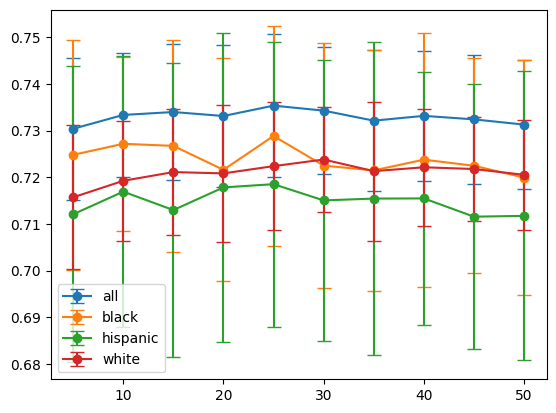

In [34]:
for col in race_cols:
    if col != 'all':
        col = col.split('_')[-1]
    plt.errorbar(outputs['min_sample_split'], outputs[f'{col}_auc_mean'], outputs[f'{col}_auc_std'],
                 label=col, marker='o', capsize=5)
plt.legend()
plt.show()